In [ ]:
# Manipulação dos dados
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from sklearn import metrics

from sklearn.model_selection import train_test_split, GridSearchCV

In [ ]:
# Definir random seed
np.random.seed(42)

In [ ]:
# Carregar os dados de codificação
encoder = pd.read_csv("encoder.csv", header=None)

# Conversão de pandas para numpy
encoder = encoder.to_numpy().tolist()

encoder = [x[0] for x in encoder]

print(encoder)

['BERHI', 'DEGLET', 'DOKOL', 'IRAQI', 'ROTANA', 'SAFAVI', 'SOGAY']


### Carregar os dados completos

In [ ]:
train_comp = np.genfromtxt("./train_comp.csv",delimiter=",")
test_comp = np.genfromtxt("./test_comp.csv",delimiter=",")

folds_comp = []

for k in range(10):
    file_name = "./fold_comp_" + str(k) + ".csv"
    folds_comp.append(np.genfromtxt(file_name,delimiter=","))
    print(folds_comp[k].shape)

# Normalizador dos dados completos
scaler_comp = StandardScaler()
scaler_comp.fit(train_comp[:,:-1])

(72, 35)
(72, 35)
(72, 35)
(72, 35)
(72, 35)
(72, 35)
(72, 35)
(72, 35)
(71, 35)
(71, 35)


StandardScaler()

### Carregar os dados Reduzidos 25 Dimensões

In [ ]:
train_red_25 = np.genfromtxt("./train_red_25.csv",delimiter=",")
test_red_25 = np.genfromtxt("./test_red_25.csv",delimiter=",")

folds_red_25 = []

for k in range(10):
    file_name = "./fold_red_25_" + str(k) + ".csv"
    folds_red_25.append(np.genfromtxt(file_name,delimiter=","))
    print(folds_red_25[k].shape)

# Normalizador dos Dados Reduzidos
scaler_red_25 = StandardScaler()
scaler_red_25.fit(train_red_25[:,:-1])

(72, 26)
(72, 26)
(72, 26)
(72, 26)
(72, 26)
(72, 26)
(72, 26)
(72, 26)
(71, 26)
(71, 26)


StandardScaler()

### Carregar os dados Reduzidos 10 Dimensões

In [ ]:
train_red_10 = np.genfromtxt("./train_red_10.csv",delimiter=",")
test_red_10 = np.genfromtxt("./test_red_10.csv",delimiter=",")

folds_red_10 = []

for k in range(10):
    file_name = "./fold_red_10_" + str(k) + ".csv"
    folds_red_10.append(np.genfromtxt(file_name,delimiter=","))
    print(folds_red_10[k].shape)

# Normalizador dos Dados Reduzidos
scaler_red_10 = StandardScaler()
scaler_red_10.fit(train_red_10[:,:-1])

(72, 11)
(72, 11)
(72, 11)
(72, 11)
(72, 11)
(72, 11)
(72, 11)
(72, 11)
(71, 11)
(71, 11)


StandardScaler()

### One Hot Encoder

In [ ]:
# One Hot Encoder - Converter a saída no estilo de saídas One Hot Encoding
encOH = OneHotEncoder(handle_unknown='ignore')
encOH.fit(train_comp[:,-1].reshape((-1,1)))

# Cross Entropy
def cross_entropy(y,log_proba_y_pred,OHencoder=encOH):
    if(len(y.shape) == 1):
        y = OHencoder.transform(y.reshape((-1,1))).toarray()
    return (-1)*np.mean(np.sum(y*log_proba_y_pred,axis=1),axis=0)



---

In [ ]:
def GridSearch_CV(distancia, k_range, folds, scaler):
    models_cv_scores = []

    for param, dist in enumerate(distancia):
        cv_scores = []

        for w in range(len(k_range)):
            model = KNeighborsClassifier(
                n_neighbors = k_range[w],
                p = distancia[param]
            )

            # Validação cruzada
            for i in range(len(folds)):

                # Escolhe um fold como validação
                data_valid = folds[i]

                # Concatena todos os outros folds como conjunto de treino
                data_train = np.empty((0,data_valid.shape[1]))

                for j in range(len(folds)):
                    if(j == i):
                        continue
                    data_train = np.r_[folds[j], data_train]

                # Separação e normalização dos dados
                X_train = scaler.transform(data_train[:,:-1])
                X_valid = scaler.transform(data_valid[:,:-1])

                Y_train = data_train[:,-1]
                Y_valid = data_valid[:,-1]

                # Treinar o modelo com os dados de treinamento
                model.fit(X_train, Y_train)

                # Verificar a acurácia com dados de validação
                cv_scores.append(model.score(X_valid, Y_valid))
            
            models_cv_scores.append(np.mean(np.array(cv_scores),axis = 0))

            print("MODELO ", len(models_cv_scores), 
                "-> Acurácia média na Validação Cruzada: {:,.5f}".format(
                    models_cv_scores[len(models_cv_scores) - 1]))
    
    # Obter o melhor modelo
    best_model = models_cv_scores.index(max(models_cv_scores))

    # Informações sobre o melhor modelo
    print("\n------------------------------------------------------------\n")
    print("\tMelhor Modelo KNN: MODELO ", best_model + 1)

    if(best_model + 1 <= len(models_cv_scores) / 2):
        print("\nQuantidade de vizinhos: ", k_range[best_model])
        print("\Melhor distancia: manhattan_distance (l1), p = 1")
        return best_model, 0
    
    idx = int(best_model - len(models_cv_scores) / 2)
    print("Quantidade de vizinhos: ", k_range[idx])
    print("Melhor distancia: euclidean_distance (l2), p = 2")
    return idx, 1

In [ ]:
k_range = list(range(1, 41))
distancias = [1, 2]

def retrainKNN(k, dist, train, test, scaler):
    model = KNeighborsClassifier(
            n_neighbors=k_range[k],
            p = dist
        )

    # Separação e normalização dos dados
    X_train = scaler.transform(train[:,:-1])
    X_test = scaler.transform(test[:,:-1])

    Y_train = train[:,-1]
    Y_test = test[:,-1]

    # Treinamento tradicional
    model.fit(X_train, Y_train)
    model_pred = model.predict(X_test)
    model_proba = model.predict_proba(X_test)[:,1]

    # Métricas de classificação
    print(f"Summary for the classifier {k_range[idx_k]}-NN with accuracy {metrics.accuracy_score(Y_test, model_pred):.4f}")
    print(metrics.classification_report(Y_test, model_pred))

    return model_pred, model_proba

    # Scores obtidos no novo treinamento
    #print("Acurácia média após novo treinamento: {:,.2f}".format(
    #    model.score(X_test, Y_test)))



---


# KNN com Dados completos
## Treinamento do Modelo

In [ ]:
idx_k, idx_dist = GridSearch_CV(distancias, k_range, folds_comp, scaler_comp)

MODELO  1 -> Acurácia média na Validação Cruzada: 0.86209
MODELO  2 -> Acurácia média na Validação Cruzada: 0.85029
MODELO  3 -> Acurácia média na Validação Cruzada: 0.85332
MODELO  4 -> Acurácia média na Validação Cruzada: 0.85657
MODELO  5 -> Acurácia média na Validação Cruzada: 0.86298
MODELO  6 -> Acurácia média na Validação Cruzada: 0.86748
MODELO  7 -> Acurácia média na Validação Cruzada: 0.87009
MODELO  8 -> Acurácia média na Validação Cruzada: 0.87154
MODELO  9 -> Acurácia média na Validação Cruzada: 0.87342
MODELO  10 -> Acurácia média na Validação Cruzada: 0.87424
MODELO  11 -> Acurácia média na Validação Cruzada: 0.87541
MODELO  12 -> Acurácia média na Validação Cruzada: 0.87581
MODELO  13 -> Acurácia média na Validação Cruzada: 0.87658
MODELO  14 -> Acurácia média na Validação Cruzada: 0.87673
MODELO  15 -> Acurácia média na Validação Cruzada: 0.87687
MODELO  16 -> Acurácia média na Validação Cruzada: 0.87743
MODELO  17 -> Acurácia média na Validação Cruzada: 0.87758
MODELO

## Retreino do modelo com todos os dados de treinamento
### Métricas de Classificação

In [ ]:
model_pred_comp, model_proba_comp = retrainKNN(k_range[idx_k], distancias[idx_dist], train_comp, test_comp, scaler_comp)

Summary for the classifier 26-NN with accuracy 0.9056
              precision    recall  f1-score   support

         0.0       1.00      0.75      0.86        16
         1.0       0.86      0.60      0.71        20
         2.0       0.85      0.97      0.90        34
         3.0       0.83      1.00      0.91        15
         4.0       0.91      1.00      0.95        39
         5.0       1.00      1.00      1.00        42
         6.0       0.83      0.71      0.77        14

    accuracy                           0.91       180
   macro avg       0.90      0.86      0.87       180
weighted avg       0.91      0.91      0.90       180



### Matriz de confusão

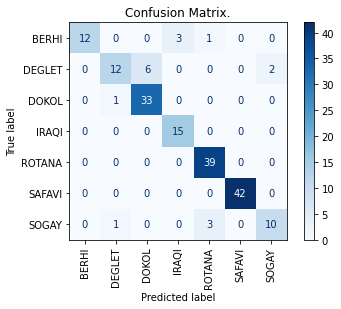

In [ ]:
test_comp_decoded = []
y_pred_ret_comp_test_decoded = []

for i in range(test_comp.shape[0]):
    test_comp_decoded.append(encoder[int(test_comp[:,-1][i])])
    y_pred_ret_comp_test_decoded.append(encoder[int(model_pred_comp[:][i])])

cm = metrics.confusion_matrix(test_comp_decoded, y_pred_ret_comp_test_decoded, 
                              labels=encoder)

disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder)
disp.plot(cmap=plt.cm.Blues, xticks_rotation= "vertical", )
plt.title(f"Confusion Matrix.");

# KNN com Dados reduzidos 25 dimensões
## Treinamento do Modelo

In [ ]:
idx_k_red25, idx_dist_red25 = GridSearch_CV(distancias, k_range, folds_red_25, scaler_red_25)

MODELO  1 -> Acurácia média na Validação Cruzada: 0.84527
MODELO  2 -> Acurácia média na Validação Cruzada: 0.83830
MODELO  3 -> Acurácia média na Validação Cruzada: 0.84293
MODELO  4 -> Acurácia média na Validação Cruzada: 0.84421
MODELO  5 -> Acurácia média na Validação Cruzada: 0.84750
MODELO  6 -> Acurácia média na Validação Cruzada: 0.85038
MODELO  7 -> Acurácia média na Validação Cruzada: 0.85324
MODELO  8 -> Acurácia média na Validação Cruzada: 0.85451
MODELO  9 -> Acurácia média na Validação Cruzada: 0.85566
MODELO  10 -> Acurácia média na Validação Cruzada: 0.85671
MODELO  11 -> Acurácia média na Validação Cruzada: 0.85771
MODELO  12 -> Acurácia média na Validação Cruzada: 0.85865
MODELO  13 -> Acurácia média na Validação Cruzada: 0.85934
MODELO  14 -> Acurácia média na Validação Cruzada: 0.86023
MODELO  15 -> Acurácia média na Validação Cruzada: 0.86109
MODELO  16 -> Acurácia média na Validação Cruzada: 0.86167
MODELO  17 -> Acurácia média na Validação Cruzada: 0.86219
MODELO

## Retreino do modelo com todos os dados de treinamento
### Métricas de Classificação

In [ ]:
model_pred_red25, model_proba_red25 = retrainKNN(
                                        k_range[idx_k_red25],
                                        distancias[idx_dist_red25],
                                        train_red_25,
                                        test_red_25,
                                        scaler_red_25)

Summary for the classifier 26-NN with accuracy 0.9000
              precision    recall  f1-score   support

         0.0       1.00      0.69      0.81        16
         1.0       0.87      0.65      0.74        20
         2.0       0.85      0.97      0.90        34
         3.0       0.82      0.93      0.87        15
         4.0       0.91      1.00      0.95        39
         5.0       1.00      1.00      1.00        42
         6.0       0.77      0.71      0.74        14

    accuracy                           0.90       180
   macro avg       0.89      0.85      0.86       180
weighted avg       0.90      0.90      0.90       180



### Matriz de confusão

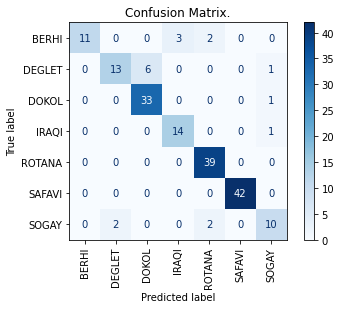

In [ ]:
test_red_25_decoded = []
y_pred_ret_red_25_test_decoded = []

for i in range(test_red_25.shape[0]):
    test_red_25_decoded.append(encoder[int(test_red_25[:,-1][i])])
    y_pred_ret_red_25_test_decoded.append(encoder[int(model_pred_red25[:][i])])

cm = metrics.confusion_matrix(test_red_25_decoded, y_pred_ret_red_25_test_decoded, 
                              labels=encoder)

disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, 
                                      display_labels=encoder)
disp.plot(cmap=plt.cm.Blues, xticks_rotation= "vertical", )
plt.title(f"Confusion Matrix.");

# KNN com Dados reduzidos 10 dimensões
## Treinamento do Modelo

In [ ]:
idx_k_red10, idx_dist_red10 = GridSearch_CV(distancias, k_range, folds_red_10, scaler_red_10)

MODELO  1 -> Acurácia média na Validação Cruzada: 0.82046
MODELO  2 -> Acurácia média na Validação Cruzada: 0.80723
MODELO  3 -> Acurácia média na Validação Cruzada: 0.81115
MODELO  4 -> Acurácia média na Validação Cruzada: 0.81415
MODELO  5 -> Acurácia média na Validação Cruzada: 0.81707
MODELO  6 -> Acurácia média na Validação Cruzada: 0.81949
MODELO  7 -> Acurácia média na Validação Cruzada: 0.82062
MODELO  8 -> Acurácia média na Validação Cruzada: 0.82111
MODELO  9 -> Acurácia média na Validação Cruzada: 0.82196
MODELO  10 -> Acurácia média na Validação Cruzada: 0.82306
MODELO  11 -> Acurácia média na Validação Cruzada: 0.82345
MODELO  12 -> Acurácia média na Validação Cruzada: 0.82366
MODELO  13 -> Acurácia média na Validação Cruzada: 0.82394
MODELO  14 -> Acurácia média na Validação Cruzada: 0.82389
MODELO  15 -> Acurácia média na Validação Cruzada: 0.82430
MODELO  16 -> Acurácia média na Validação Cruzada: 0.82484
MODELO  17 -> Acurácia média na Validação Cruzada: 0.82490
MODELO

## Retreino do modelo com todos os dados de treinamento
### Métricas de Classificação

In [ ]:
model_pred_red10, model_proba_red10 = retrainKNN(
                                        k_range[idx_k_red10],
                                        distancias[idx_dist_red10],
                                        train_red_10,
                                        test_red_10,
                                        scaler_red_10)

Summary for the classifier 26-NN with accuracy 0.8444
              precision    recall  f1-score   support

         0.0       1.00      0.25      0.40        16
         1.0       0.72      0.65      0.68        20
         2.0       0.89      0.94      0.91        34
         3.0       0.78      0.93      0.85        15
         4.0       0.80      1.00      0.89        39
         5.0       0.98      1.00      0.99        42
         6.0       0.67      0.57      0.62        14

    accuracy                           0.84       180
   macro avg       0.83      0.76      0.76       180
weighted avg       0.85      0.84      0.83       180



### Matriz de confusão

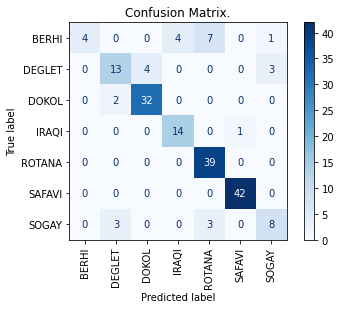

In [ ]:
test_red_10_decoded = []
y_pred_ret_red_10_test_decoded = []

for i in range(test_red_10.shape[0]):
    test_red_10_decoded.append(encoder[int(test_red_10[:,-1][i])])
    y_pred_ret_red_10_test_decoded.append(encoder[int(model_pred_red10[:][i])])

cm = metrics.confusion_matrix(test_red_10_decoded, y_pred_ret_red_10_test_decoded, 
                              labels=encoder)

disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, 
                                      display_labels=encoder)
disp.plot(cmap=plt.cm.Blues, xticks_rotation= "vertical", )
plt.title(f"Confusion Matrix.");